# Setting the hierarchy in DisMod-MR

The goal of this document is to demonstrate how to set the spatial hierarchy for the random effects in DisMod-MR.

The examples are based on a spatial hierarchy of Japan, provided by Ver Bilano, and included in the examples directory.

In [1]:
import dismod_mr, numpy as np, pandas as pd

In [2]:
df = pd.read_csv('hierarchy.csv')

In [3]:
df.head()

,Prefecture,Region,Population
0,Aichi,Chubu,"7,043,235"
1,Akita,Tohoku,"1,189,215"
2,Aomori,Tohoku,"1,475,635"
3,Chiba,Kanto,"5,926,349"
4,Ehime,Shikoku,"1,493,126"


First, we will use simulation to generate $n$ rows of input data.

In [4]:
import random

In [5]:
n = 100

dm = dismod_mr.data.ModelData()
inp = pd.DataFrame(columns=dm.input_data, index=range(n))

# data type, value, and uncertainty
inp['data_type'] = 'p'
inp['value'] = .5 + .1*np.random.randn(n)
inp['effective_sample_size'] = 1000.

# geographic information (to be used for random effects)
inp['area'] = [random.choice(df.Prefecture) for i in range(n)]

inp['sex'] = 'total'
inp['age_start'] = 50
inp['age_end'] = 50

inp['standard_error'] = np.nan
inp['upper_ci'] = np.nan
inp['lower_ci'] = np.nan

# put data in model
dm.add_data(inp)

In [6]:
# set model parameters for simple fit
dm.parameters['p'] = {'level_value': {'age_after': 100, 'age_before': 1, 'value': 0.},
                      'parameter_age_mesh': [0, 100]}

The following code generates a single level hierarchy, with all prefectures below the national level:

In [7]:
for p in df.Prefecture:
    dm.hierarchy.add_edge('all', p)

That is all there is to it!

In [8]:
dm.vars = dismod_mr.model.asr(dm, 'p', rate_type='neg_binom')
%time dismod_mr.fit.asr(dm, 'p', iter=10_000, burn=5_000, thin=5)

finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.09
sampling from posterior

CPU times: user 17min 10s, sys: 192 ms, total: 17min 10s
Wall time: 17min 11s


(<pymc.NormalApproximation.MAP at 0x7f5d4e0cf630>,
 <pymc.MCMC.MCMC at 0x7f5d4df98860>)

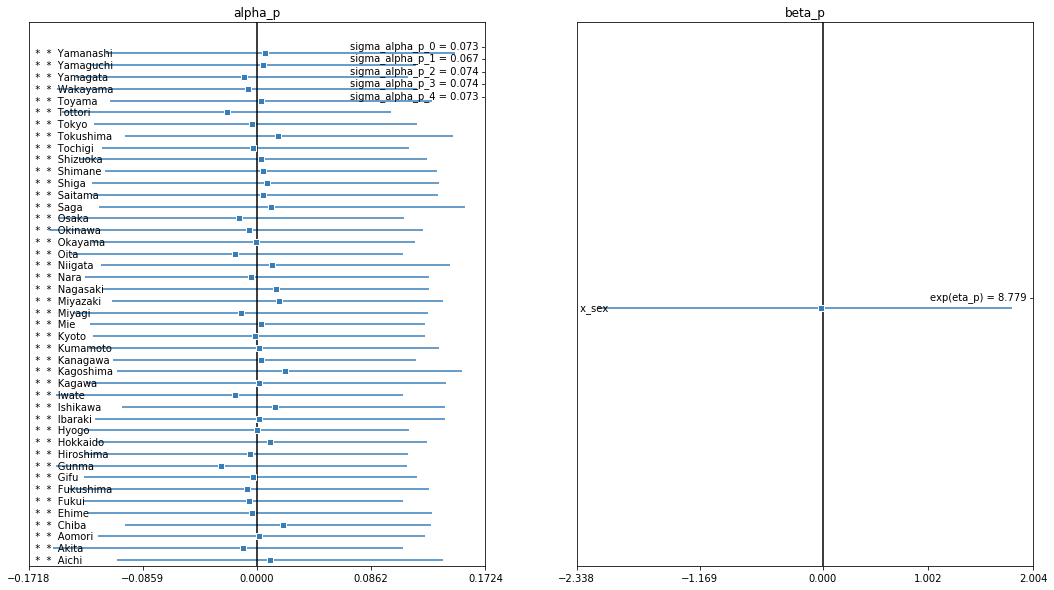

In [9]:
dismod_mr.plot.effects(dm, 'p', figsize=(18,10))

To use a two-level hierarchy instead, simply build the regions into the hierarchy graph:

In [10]:
dm = dismod_mr.data.ModelData()
dm.add_data(inp)
dm.parameters['p'] = {'level_value': {'age_after': 100, 'age_before': 1, 'value': 0.},
                      'parameter_age_mesh': [0, 100]}

In [11]:
for i, row in df.iterrows():
    dm.hierarchy.add_edge('all', row['Region'])
    dm.hierarchy.add_edge(row['Region'], row['Prefecture'])

In [12]:
dm.vars = dismod_mr.model.asr(dm, 'p', rate_type='neg_binom')
%time dismod_mr.fit.asr(dm, 'p', iter=10_000, burn=5_000, thin=5)

finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.1
sampling from posterior

CPU times: user 20min 2s, sys: 1.87 s, total: 20min 3s
Wall time: 20min 4s


(<pymc.NormalApproximation.MAP at 0x7f5d4b743f60>,
 <pymc.MCMC.MCMC at 0x7f5d4bb1d7f0>)

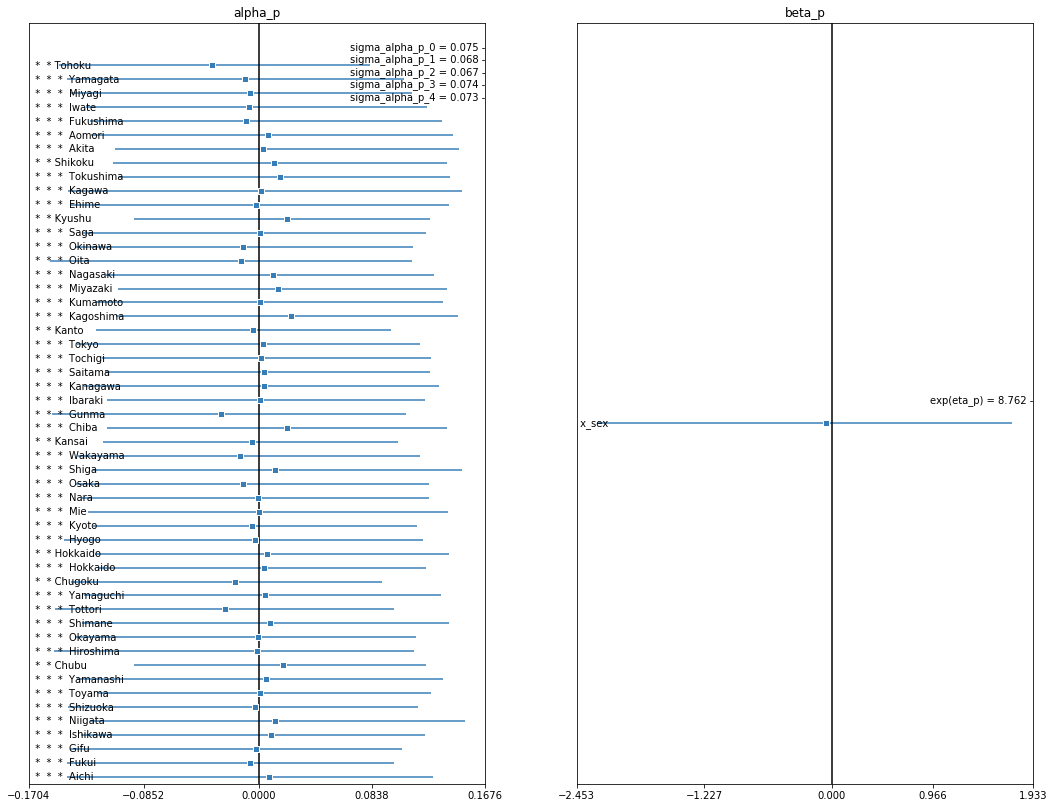

In [13]:
dismod_mr.plot.effects(dm, 'p', figsize=(18,14))

It would be great to extend this example so that the results differed in a meaningful way when using one- and two-level hierarchical models.  This is left as an exercise to the reader.

In [14]:
!date

Tue Jul 23 15:32:40 PDT 2019
